# Rossmann Stores Sales Prediction

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [40]:
#Read store dataset
store = pd.read_csv('store.csv')
print(store.shape)
store.head(10)

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [41]:
#Read training dataset
train = pd.read_csv('train.csv',parse_dates = True, index_col = 'Date')
print(train.shape)
train.head(10)

(1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2015-07-31,6,5,5651,589,1,1,0,1
2015-07-31,7,5,15344,1414,1,1,0,1
2015-07-31,8,5,8492,833,1,1,0,1
2015-07-31,9,5,8565,687,1,1,0,1


### Missing Values 

In [42]:
print("train:\n\n", train.isnull().sum(),  
     "\n\nstore:\n\n", store.isnull().sum())

train:

 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 

store:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [43]:
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)
store.head(5)

,Store,StoreType,Assortment,CompetitionDistance,Promo2
0,1,c,a,1270.0,0
1,2,a,a,570.0,1
2,3,a,a,14130.0,1
3,4,c,c,620.0,0
4,5,a,a,29910.0,0


Text(0.5,1,'Distributin of Store Competition Distance')

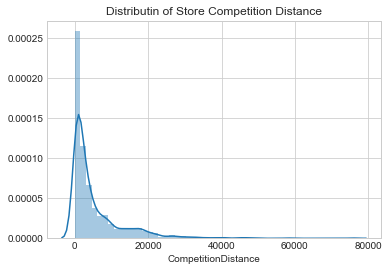

In [44]:
# Distribution of competition distance
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

In [45]:
# replace missing values in CompetitionDistance with median
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

In [46]:
# extract year, month, day and week of year from "Date"
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train = train.reset_index()

In [47]:
train.head(5)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


### Joining tables

In [48]:
df = pd.merge(train, store, how='left', on='Store')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


### Droping rows with no effect on prediction

In [49]:
df = df[df.Open != 0]

In [50]:
df.shape

(844392, 17)

In [51]:
df = df.drop('Open', axis=1)

In [52]:
df.shape

(844392, 16)

In [53]:
df[df.Sales == 0]['Store'].sum()

31460

In [54]:
df[df.Sales == 0]['Sales'].sum()/df.Sales.sum()

0.0

In [55]:
df = df[df.Sales != 0]

In [56]:
df.shape

(844338, 16)

### Feauture Engineering 

In [57]:
#Nominal attributes
set(df.StateHoliday), set(df.StoreType), set(df.Assortment)

({0, '0', 'a', 'b', 'c'}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
Date                   844338 non-null datetime64[ns]
Store                  844338 non-null int64
DayOfWeek              844338 non-null int64
Sales                  844338 non-null int64
Customers              844338 non-null int64
Promo                  844338 non-null int64
StateHoliday           844338 non-null object
SchoolHoliday          844338 non-null int64
Year                   844338 non-null int64
Month                  844338 non-null int64
Day                    844338 non-null int64
WeekOfYear             844338 non-null int64
StoreType              844338 non-null object
Assortment             844338 non-null object
CompetitionDistance    844338 non-null float64
Promo2                 844338 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11), object(3)
memory usage: 109.5+ MB


In [59]:
df.loc[df.StateHoliday == 0,'StateHoliday'] = df.loc[df.StateHoliday == 0,'StateHoliday'].astype(str)

In [60]:
#Obtain copy of dataset for further use
df1 =  df.copy()
dfv = df.sample(n=5000, random_state=1)

In [61]:
# Adding New variable AvgSales 

sales = df1[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales.head(10)

Sales
Year Month Store             
2013 1     1      4939.653846
           2      4429.653846
           3      6371.269231
           4      9027.423077
           5      4209.307692
           6      5856.346154
           7      7232.000000
           8      4703.576923
           9      4885.230769
           10     5001.615385

In [62]:
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()
sales.head(10)

,Year,Month,Store,AvgSales
0,2013,1,1,4939.653846
1,2013,1,2,4429.653846
2,2013,1,3,6371.269231
3,2013,1,4,9027.423077
4,2013,1,5,4209.307692
5,2013,1,6,5856.346154
6,2013,1,7,7232.000000
7,2013,1,8,4703.576923
8,2013,1,9,4885.230769
9,2013,1,10,5001.615385


In [63]:
df1['sales_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [64]:
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
df1 = pd.merge(df1, sales, how='left', on=('sales_key'))
df1.head(5)

,Date,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,sales_key,AvgSales
0,2015-07-31,1,5,5263,555,1,0,1,2015,7,31,31,c,a,1270.0,0,201571,4491.333333
1,2015-07-31,2,5,6064,625,1,0,1,2015,7,31,31,a,a,570.0,1,201572,4954.259259
2,2015-07-31,3,5,8314,821,1,0,1,2015,7,31,31,a,a,14130.0,1,201573,6797.592593
3,2015-07-31,4,5,13995,1498,1,0,1,2015,7,31,31,c,c,620.0,0,201574,10256.851852
4,2015-07-31,5,5,4822,559,1,0,1,2015,7,31,31,a,a,29910.0,0,201575,4599.629630


In [65]:
# Adding New variable AvgCustomer

cust = df1[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

df1['cust_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

df1 = df1.drop('Customers', axis=1)# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

df1 = pd.merge(df1, cust, how="left", on=('cust_key'))

In [66]:
df1.head(5)

,Date,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,sales_key,AvgSales,cust_key,AvgCustomer
0,2015-07-31,1,5,5263,1,0,1,2015,7,31,31,c,a,1270.0,0,201571,4491.333333,201571,519.407407
1,2015-07-31,2,5,6064,1,0,1,2015,7,31,31,a,a,570.0,1,201572,4954.259259,201572,621.222222
2,2015-07-31,3,5,8314,1,0,1,2015,7,31,31,a,a,14130.0,1,201573,6797.592593,201573,682.888889
3,2015-07-31,4,5,13995,1,0,1,2015,7,31,31,c,c,620.0,0,201574,10256.851852,201574,1294.259259
4,2015-07-31,5,5,4822,1,0,1,2015,7,31,31,a,a,29910.0,0,201575,4599.629630,201575,521.703704


In [67]:
# stateholiday variable

df1['StateHoliday'] = df1.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})
df1 = df1.drop(['cust_key','sales_key','Store','Date'], axis=1)

In [68]:
df1.head(5)

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,AvgSales,AvgCustomer
0,5,5263,1,0,1,2015,7,31,31,c,a,1270.0,0,4491.333333,519.407407
1,5,6064,1,0,1,2015,7,31,31,a,a,570.0,1,4954.259259,621.222222
2,5,8314,1,0,1,2015,7,31,31,a,a,14130.0,1,6797.592593,682.888889
3,5,13995,1,0,1,2015,7,31,31,c,c,620.0,0,10256.851852,1294.259259
4,5,4822,1,0,1,2015,7,31,31,a,a,29910.0,0,4599.629630,521.703704


### Data Analysis

In [69]:
corr = df1.corr()

Text(0.5,1,'Correlation Heatmap')

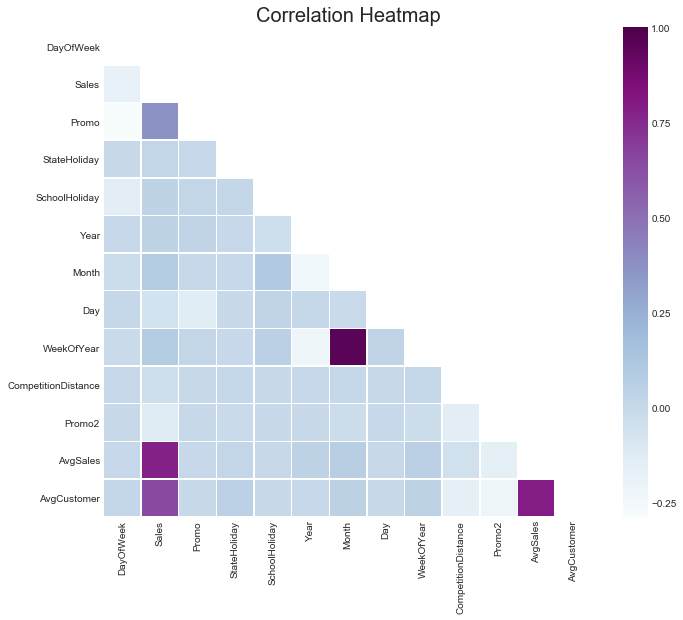

In [70]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(corr, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

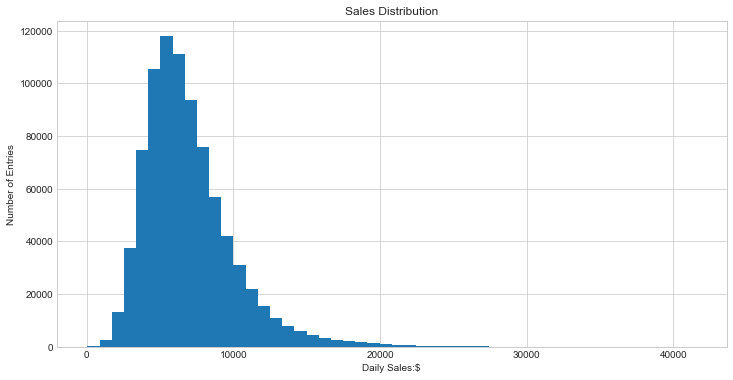

In [71]:
plt.figure(figsize=(12, 6))
plt.xlabel('Daily Sales:$')
plt.ylabel('Number of Entries')
plt.title('Sales Distribution')
plt.hist(x=df.Sales,bins=50);

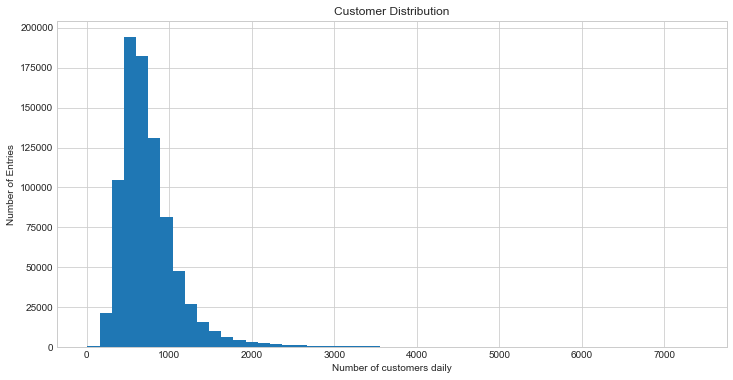

In [72]:
plt.figure(figsize=(12, 6))
plt.xlabel('Number of customers daily')
plt.ylabel('Number of Entries')
plt.title('Customer Distribution')
plt.hist(x=df.Customers,bins=50);

In [73]:
# set up credential file for plotly
plotly.tools.set_credentials_file(username='chetanrajk', api_key='mmLKFIRhvDgbLwbgMi5Z')

In [74]:
cust_s = [go.Scatter(x=dfv.Customers, y=dfv.Sales, mode='markers', 
                     marker=dict(size=10,color=dfv.CompetitionDistance,
                                 colorbar=dict(title='Competition Distance'),colorscale='Earth'))]
layout9 = go.Layout(title='Sales vs. Number Of Customers', 
                   xaxis=dict(title='Number Of Customers'), yaxis=dict(title='Sales'))
fig9 = go.Figure(data=cust_s, layout=layout9)
py.iplot(fig9)

In [76]:
distance_s = [go.Scatter(x=dfv.CompetitionDistance, y=dfv.Sales, mode='markers', 
                     marker=dict(size=10,color=dfv.Customers,
                                 colorbar=dict(title='Number Of Customers'),colorscale='Jet'))]
layout10 = go.Layout(title='Sales vs. Competition Distance', 
                   xaxis=dict(title='Competition Distance'), yaxis=dict(title='Sales'))
fig10 = go.Figure(data=distance_s, layout=layout10)
py.iplot(fig10)

In [77]:
promo0 = df.query('Promo==0')
promo0 = promo0.rename(columns={'Sales':'No_Promotion_Sales'})
promo1 = df.query('Promo==1')
promo1 = promo1.rename(columns={'Sales':'Promotion_Sales'})
x1 = promo0.No_Promotion_Sales
x2 = promo1.Promotion_Sales

Text(0,0.5,'Sales')

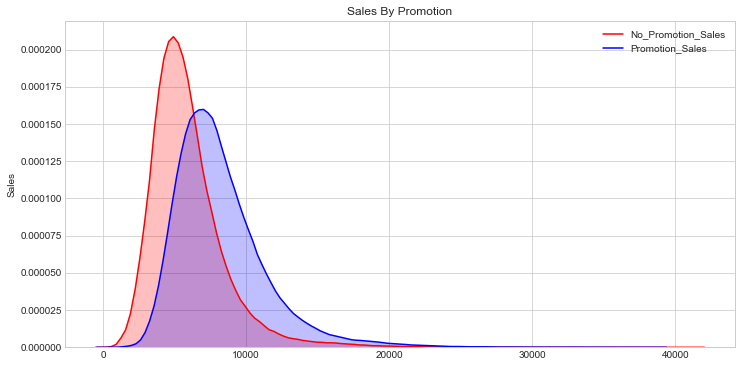

In [78]:

plt.figure(figsize=(12,6))
ax = sns.kdeplot(x1, shade=True, color="r")
ax = sns.kdeplot(x2, shade=True, color="b")
plt.title("Sales By Promotion")
plt.ylabel('Sales')

## Prediction Models

In [ ]:
df1.shape
#dfd = df1.sample(n=50000, random_state=1)

In [42]:
#Divide training dataset in x and y
X = df1.drop('Sales', axis=1)
y = df1.Sales

In [43]:
y.head(10)

0     5263
1     6064
2     8314
3    13995
4     4822
5     5651
6    15344
7     8492
8     8565
9     7185
Name: Sales, dtype: int64

In [44]:
xd = X.copy()
xd = pd.get_dummies(xd)

In [45]:
xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.2, random_state=1)

## 1. Linear Regression

In [46]:
#Build linear regression model
lin_model = LinearRegression()

#Train model on training dataset
lin_model.fit(xd_train, yd_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
#Error functions

def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  

def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_pred)), axis=0))

    return loss

In [48]:
#Predict using model

yd_predicted = lin_model.predict(xd_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yd_train, yd_predicted))
print("MAPE :",mape(yd_train, yd_predicted))

The model performance for training dataset:

RMSPE : 0.2352235766859213
MAPE : 17.00591523411027


In [49]:
#Predict target on test data using model

yd_test_predicted = lin_model.predict(xd_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yd_test, yd_test_predicted))
print("MAPE :",mape(yd_test, yd_test_predicted))

The model performance for training dataset:

RMSPE : 0.235062499216504
MAPE : 17.033209167918606


## 2. Random Forest 

In [50]:
xl = X.copy()

# Lable encoding

label = LabelEncoder()
xl.StateHoliday = label.fit_transform(xl.StateHoliday)
xl.Assortment = label.fit_transform(xl.Assortment)
xl.StoreType = label.fit_transform(xl.StoreType)

In [51]:
xl_train,xl_test,yl_train,yl_test = train_test_split(xl,y,test_size=0.2, random_state=1)

In [52]:
#Build random forest model
rdf_model = RandomForestRegressor(n_estimators=30)

#Train model on training dataset
rdf_model.fit(xl_train, yl_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
#Predict using model

yl_pred = rdf_model.predict(xl_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))

The model performance for training dataset:

RMSPE : 0.047144820415995325
MAPE : 3.359428291015845


In [56]:
#Predict target on test data using model

yl_pred_test = rdf_model.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))

The model performance for training dataset:

RMSPE : 0.1187577555204927
MAPE : 8.828191765576593


## 3. Decision Tree

In [57]:
#Build decision tree model
tree_model = DecisionTreeRegressor(min_samples_leaf=20)

#Train model on training dataset
tree_model.fit(xl_train, yl_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
#Predict using model

yl_pred = tree_model.predict(xl_train)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_train, yl_pred))
print("MAPE :",mape(yl_train, yl_pred))

The model performance for training dataset:

RMSPE : 0.1312544072700217
MAPE : 9.66558881822088


In [59]:
#Predict target on test data using model

yl_pred_test = tree_model.predict(xl_test)

#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSPE :",rmspe(yl_test, yl_pred_test))
print("MAPE :",mape(yl_test, yl_pred_test))

The model performance for training dataset:

RMSPE : 0.15163745919668747
MAPE : 11.037071216273942


## Feature Importance

In [60]:
features = xl_train.columns
importances = rdf_model.feature_importances_
indices = np.argsort(importances)

Text(0.5,0,'Relative Importance')

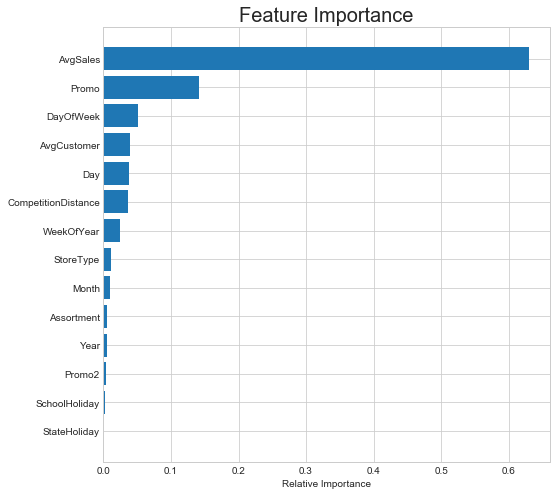

In [63]:
plt.figure(figsize=(8,8))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')